In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas_datareader as pdr
from master_function import data_preprocessing, plot_train_test_values
from master_function import calculate_directional_accuracy
from sklearn.metrics import mean_squared_error

In [3]:
start_date='2020-01-01'
end_date = '2023-06-01'
data = np.array((pdr.get_data_fred('SP500', start = start_date, end = end_date)).dropna())

In [4]:
#20-day autocorrelation of the close prices
rolling_autocorr = pd.DataFrame(data).rolling(window =20).apply(lambda x: x.autocorr(lag=1)).dropna()
rolling_autocorr = np.reshape(np.array(rolling_autocorr), (-1))
#lambda function, also known as an anonymous function, is a small, unnamed function that can have any number of arguments but can only have one expression.

In [7]:
#пример-Create an anonymous function to divide two variables
#divide = lambda x, y: x / y
# Call the function
#result = divide(10, 2)
#result

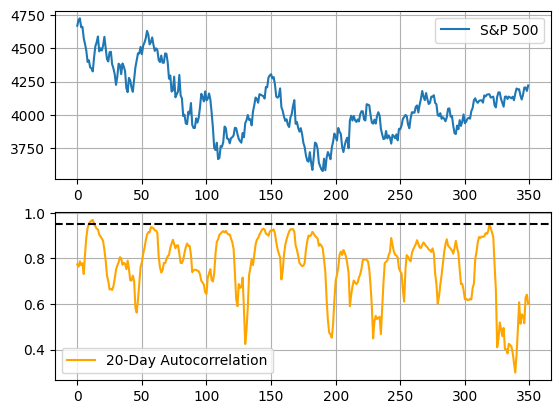

In [8]:
#визуализация график корреляций close prices 20d
fig, axes = plt.subplots(nrows = 2, ncols = 1)
axes[0].plot(data[-350:,], label = 'S&P 500', linewidth = 1.5)
axes[1].plot(rolling_autocorr[-350:,], label = '20-Day Autocorrelation',
 color = 'orange', linewidth = 1.5)
axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()
axes[1].axhline(y = 0.95, color = 'black', linestyle = 'dashed')

In [10]:
num_lags = 500
train_test_split = 0.80
num_neurons_in_hidden_layers = 128
num_epochs = 100
batch_size = 20
x_train, y_train, x_test, y_test = data_preprocessing(rolling_autocorr, num_lags, train_test_split)

In [11]:
#input arrays into three-dimensional structures для LSTM
x_train = x_train.reshape((-1, num_lags, 1))
x_test = x_test.reshape((-1, num_lags, 1))

In [13]:
#lstm архитектура
model = Sequential()
model.add(LSTM(units = num_neurons_in_hidden_layers, input_shape=(num_lags, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
#batch normalization and a dropout of 10%
#add output layer
model.add(Dense(units = 1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
early_stopping = EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)

In [14]:
#fit (train) model
model.fit(x_train, y_train, epochs = num_epochs, batch_size = batch_size, callbacks = [early_stopping])

Epoch 1/100
14/14 [==============================] - 7s 286ms/step - loss: 0.5260
Epoch 2/100
14/14 [==============================] - 4s 290ms/step - loss: 0.2340
Epoch 3/100
14/14 [==============================] - 4s 276ms/step - loss: 0.0806
Epoch 4/100
14/14 [==============================] - 4s 281ms/step - loss: 0.0163
Epoch 5/100
14/14 [==============================] - 4s 295ms/step - loss: 0.0092
Epoch 6/100
14/14 [==============================] - 4s 277ms/step - loss: 0.0100
Epoch 7/100
14/14 [==============================] - 4s 288ms/step - loss: 0.0076
Epoch 8/100
14/14 [==============================] - 4s 294ms/step - loss: 0.0077
Epoch 9/100
14/14 [==============================] - 4s 279ms/step - loss: 0.0082
Epoch 10/100
14/14 [==============================] - 4s 281ms/step - loss: 0.0057
Epoch 11/100
14/14 [==============================] - 4s 272ms/step - loss: 0.0061
Epoch 12/100
14/14 [==============================] - 4s 272ms/step - loss: 0.0070
Epoch 13/100


In [17]:
#predict in and ou of sample and plot
y_predicted_train = np.reshape(model.predict(x_train), (-1, 1))
# Predicting out-of-sample
y_predicted = np.reshape(model.predict(x_test), (-1, 1))

3/3 [==============================] - 0s 88ms/step


In [19]:
def plot_train_test_values(window, train_window, y_train, y_test, y_predicted):
    prediction_window = window
    first = train_window
    second = window - first
    
    # Ensure all inputs are properly shaped
    y_predicted = np.reshape(y_predicted, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    y_train = np.reshape(y_train, (-1, 1))
    
    # Verify shapes match
    if len(y_test) < second:
        second = len(y_test)  # Adjust second if test data is shorter
        window = first + second  # Update window size
    
    plotting_time_series = np.zeros((window, 3))  # Use updated window size
    
    try:
        plotting_time_series[0:first, 0] = y_train[-first:].flatten()
        plotting_time_series[first:first+second, 1] = y_test[:second].flatten()
        plotting_time_series[first:first+second, 2] = y_predicted[:second].flatten()
        
        plotting_time_series[0:first, 1] = np.nan
        plotting_time_series[0:first, 2] = np.nan
        plotting_time_series[first:, 0] = np.nan
        
        plt.figure(figsize=(12, 6))
        plt.plot(plotting_time_series[:, 0], label='Training data', color='black', linewidth=2.5)
        plt.plot(plotting_time_series[:, 1], label='Test data', color='black', linestyle='dashed', linewidth=2)
        plt.plot(plotting_time_series[:, 2], label='Predicted data', color='red', linewidth=1)
        plt.axvline(x=first, color='black', linestyle='--', linewidth=1)
        plt.grid()
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"Error in plotting: {e}")
        print(f"Shapes - y_train: {y_train.shape}, y_test: {y_test.shape}, y_predicted: {y_predicted.shape}")
        print(f"Window: {window}, first: {first}, second: {second}")

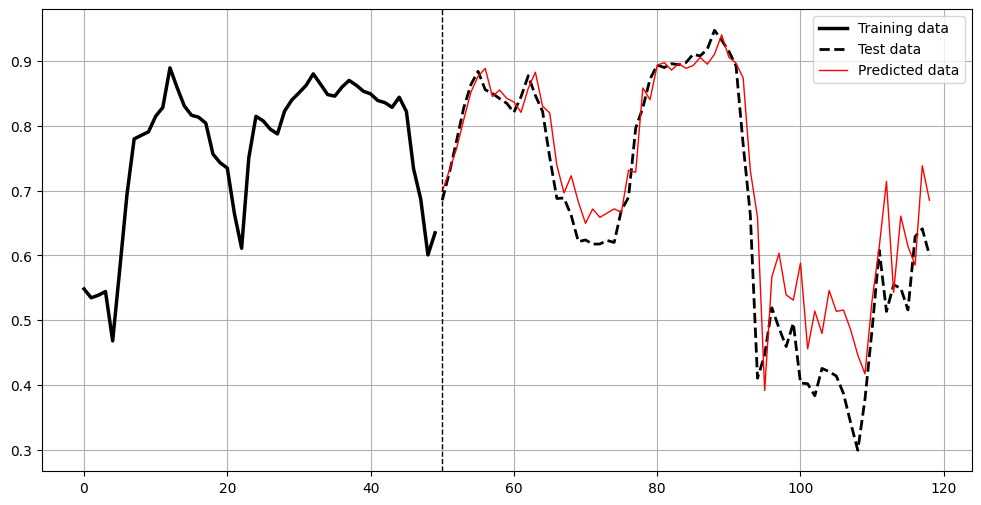

In [20]:
# Plotting
plot_train_test_values(300, 50, y_train, y_test, y_predicted)